#  Minimum Spanning Tree Problem 

## Gurobi Lazy cuts callback


In [26]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display


In [27]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos, width=0.1, fontsize=9)
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    

def DrawSol (x):
    for i,j in G.edges():
        lab = x[i,j].x
        G[i][j]['capacity'] = x[i,j].x
        if x[i,j].x > 0.00001:
            if x[i,j].x > 0.999999:
                DrawG.add_edge(i, j, color='black', label=lab, fontsize=9)
            else:
                DrawG.add_edge(i, j, color='red', label=lab)
    path=str(basename)+'_sol.svg'
    DrawG.draw (path=path, format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    
class args:
    filename = None
    scale = 60

### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [28]:
args.filename = "mst.gml"
args.scale = 40

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


In [29]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(),\
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.BINARY, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [30]:
mst.optimize()

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]
Found heuristic solution: objective 21270.000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 1 rows, 42 columns, 42 nonzeros
Variable types: 0 continuous, 42 integer (39 binary)

Root relaxation: objective 5.016000e+03, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5016.0000000 5016.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 5016 21270 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.016000000000e+03, best bound 5.01

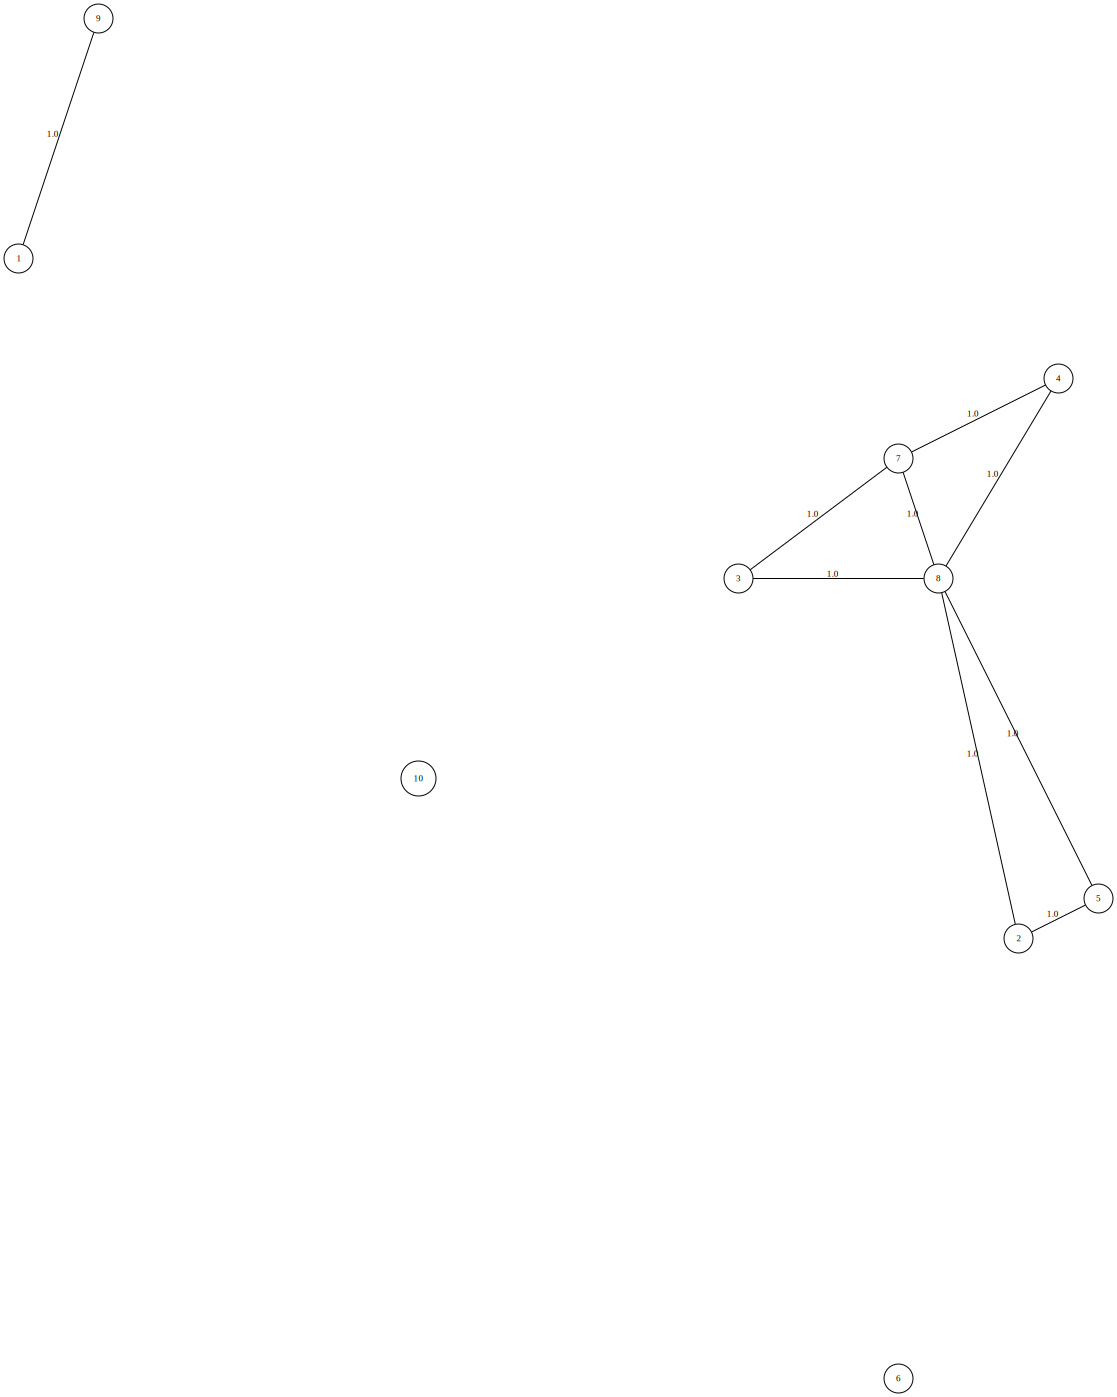

In [31]:
DrawInitialGraph()
DrawSol(x)
display(SVG(filename=basename+'_sol.svg'))

## Data needed to the callback

Our callback needs: 
   1. The graph $G$
   2. The variables $x$
   3. The separation routine
   4. The number of SECs generated so far
 
The above data are added to the ``mst`` Model. Note the ``_`` before the data name

In [32]:
mst._graph = G
mst._vars = x
mst._nSEC = 0



In [33]:
import math
import itertools

def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
        
        #
        # Make a graph working copy
        # Not efficient !!!
        #
        
        solG = nx.Graph([(u,v) for (u,v) in G.edges() \
                         if math.isclose(xrel[u,v], 1.0, abs_tol=1E-3)])

        #
        # Check if solG is connected
        #
        
        for cc in nx.connected_components(solG):
            if G.subgraph(cc).number_of_edges() > len(cc) - 1 and len(cc) > 2:
                seclhs = gb.quicksum(x[u,v] if (u,v) in x else x[v,u] \
                                 for u,v in itertools.combinations(cc, 2))
            
                model.cbLazy(seclhs <= len(cc) - 1)
                

In [34]:
mst.reset()
mst.Params.lazyConstraints = 1
mst.optimize(SECcallback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 1 rows, 45 columns and 45 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]
Presolve time: 0.00s
Presolved: 1 rows, 45 columns, 45 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 5.016000e+03, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    6735.0000000 6735.00000  0.00%     -    0s

Cutting planes:
  Lazy constraints: 5

Explored 0 nodes (9 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 6735 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.

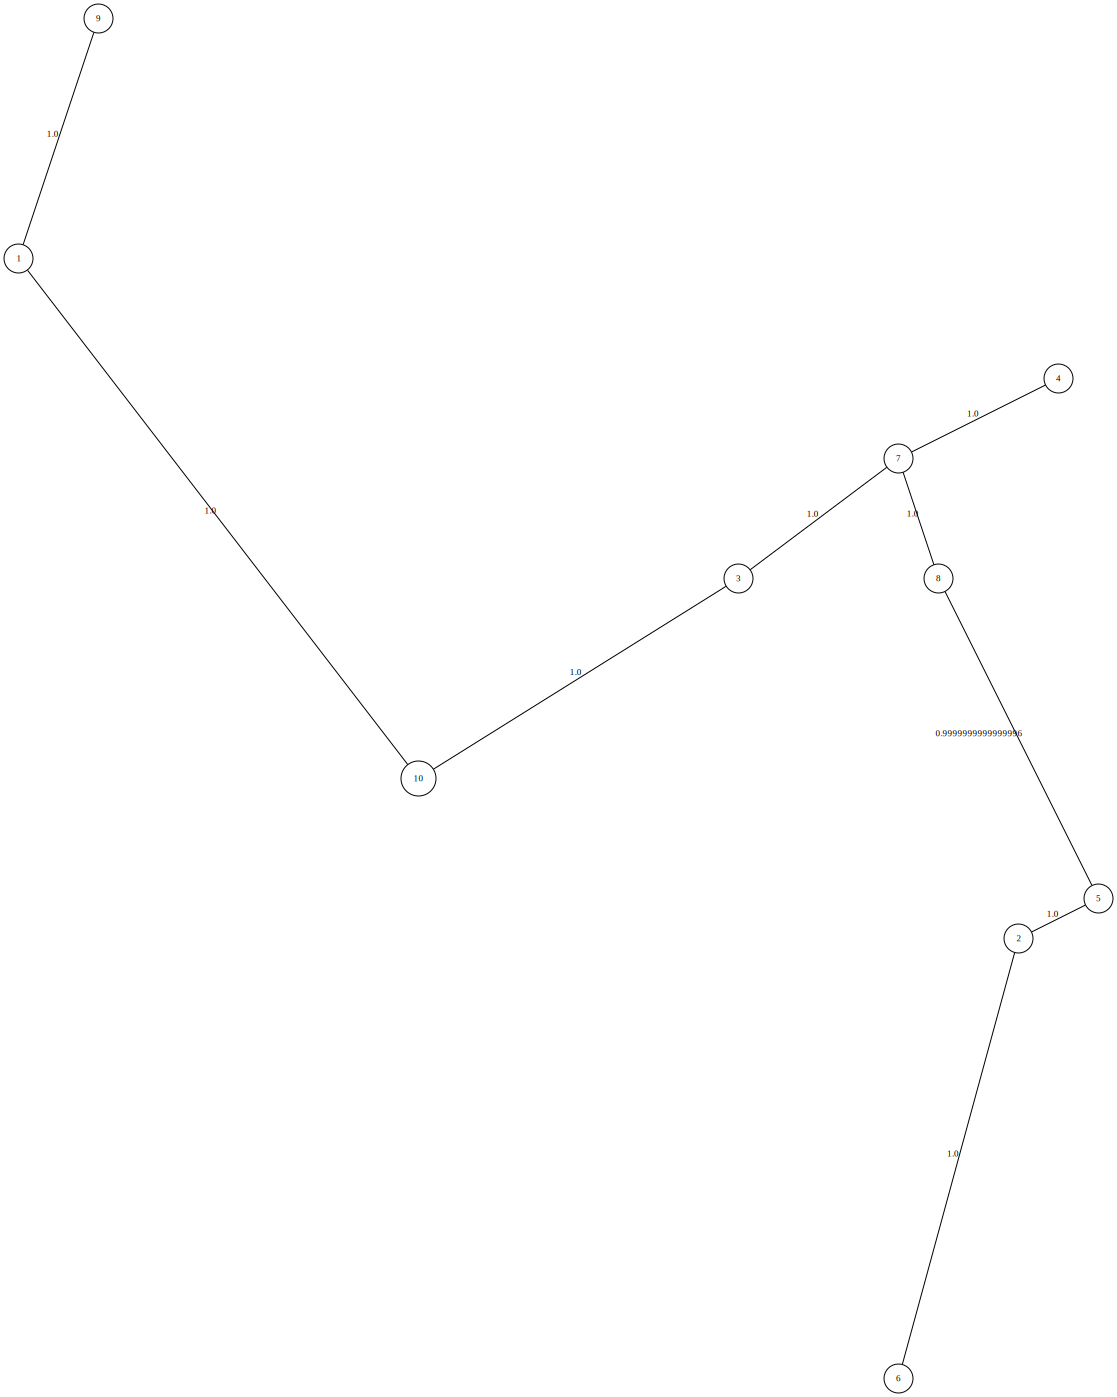

In [35]:
DrawInitialGraph()
DrawSol(x)
display(SVG(filename=basename+'_sol.svg'))